In [55]:
# import
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import os
import math
# label
# =========================
def class_2_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    else:
        label = "1"
    return label

def class_3_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    elif "雙踝" in root:
        label = "1"
    elif "三踝" in root:
        label = "2"
    return label
# =========================

def load_path(path, class_count):
    dataset = []
    class_type = ''
    if class_count == 2:
        class_type = class_2_type
    elif class_count == 3:
        class_type = class_3_type   

    for root, dirs, files in os.walk(path):
        for file in files:
            label = class_type(root)
            if label != "":
                dataset.append(
                                {   
                                    'uuid': root.split("\\")[-1],
                                    'label': label,
                                    'image_path': os.path.join(root, file)
                                }
                            )

    return dataset

In [151]:
# from keras.preprocessing import image
# import matplotlib.cm as cm
# def make_gradcam_heatmap(img_array_front, img_array_side, model, pred_index=None):
#     # 建立一個模型，同時輸出最後一個卷積層和整個模型的預測結果
#     # front
#     layer_front = model.get_layer("resnet50")
#     last_conv_layer_name_front="conv5_block3_3_conv"
#     last_conv_layer_front = layer_front.get_layer(last_conv_layer_name_front)

#     # side
#     layer_side = model.get_layer("efficientnetb0")
#     last_conv_layer_name_side="top_conv"
#     last_conv_layer_side = layer_side.get_layer(last_conv_layer_name_side)
    
#     # grad_model = tf.keras.models.Model(
#     #     model.inputs, [last_conv_layer.output, model.output]
#     # )
#     grad_model = tf.keras.models.Model(
#         inputs=[model.input[0], model.input[1]],
#         outputs=[last_conv_layer_front.output, last_conv_layer_side.output, model.output]
#     )
    
#     # 計算對於輸入圖像的預測類別，相對於最後一個卷積層的梯度
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array_front, img_array_side)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     # 輸出分類神經元相對於最後一個卷積層的輸出特徵圖的梯度
#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     # 這是一個向量，其中每個數字都是特定特徵圖通道上的梯度的平均強度
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # 將特徵圖乘以權重，等於該特徵圖中的某些區域對於該分類的重要性
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap) # 然後將所有通道相加以獲得熱圖

#     # 為了視覺化，將熱圖正規化0~1之間
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()


# def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
#     # 載入原始圖像
#     img = tf.keras.utils.load_img(img_path)
#     img = tf.keras.utils.img_to_array(img)

#     # 將熱圖重新縮放到0-255的範圍
#     heatmap = np.uint8(255 * heatmap)

#     # 使用Jet色彩映射將熱圖上色
#     jet = cm.get_cmap("Purples")

#     # 使用Jet色彩映射的RGB值
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # 創建帶有RGB色彩的熱圖圖像
#     jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

#     # 在原始圖像上疊加熱圖
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
#     plt.imshow(superimposed_img)
#     plt.axis('off')  # 不顯示坐標軸
#     plt.show()

import matplotlib.pyplot as plt
import cv2
def plot_img(image_path):
    print(image_path)
    # image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV 讀取的圖像是 BGR 需要轉為 RGB
    image1 = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
    image2 = cv2.imdecode(np.fromfile(image_path.replace("front", "side"), dtype=np.uint8), cv2.IMREAD_COLOR)



    # **顯示圖片**
    plt.figure(figsize=(8, 5))  # 設定圖片大小

    # 顯示第一張圖（front）
    plt.subplot(1, 2, 1)  # (行數, 列數, 當前索引)
    plt.imshow(image1)
    plt.title("AP(Mortise) View")
    plt.axis("off")  # 隱藏座標軸

    # 顯示第二張圖（side）
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title("Lateral View")
    plt.axis("off")

    plt.suptitle(image_path.split("\\")[-1])

    plt.show()  # 顯示圖片





In [56]:
## 參數設置
image_dir = "E:\\data_bone\\9-a+b_swift_cut_正確_V2\\front"
concat_type = "concat1"
class_count = 3

In [57]:
## load data and  labels
# =========================
data = load_path(image_dir, class_count)
labels = []
filepaths = []
for row in data:
    labels.append(row['label'])
    filepaths.append(row['image_path'])

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)
# =========================


In [58]:
## split image
# =========================
train_df_front, test_df_front = train_test_split(images, train_size=0.8, shuffle=True, random_state=1, stratify=images['Label'])
print("Training set label distribution:\n", train_df_front['Label'].value_counts(normalize=False))
print("Test set label distribution:\n", test_df_front['Label'].value_counts(normalize=False))
# =========================

preprocessing_function_chosen_front = tf.keras.applications.resnet50.preprocess_input
preprocessing_function_chosen_side = tf.keras.applications.efficientnet.preprocess_input

# front images
# =========================
train_generator_front = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False,
                                                                    preprocessing_function=preprocessing_function_chosen_front,
                                                                    validation_split=0.2)
test_generator_front = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function_chosen_front)

train_images_front = train_generator_front.flow_from_dataframe(
    dataframe=train_df_front,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42,
    subset='training'
)

val_images_front = train_generator_front.flow_from_dataframe(
    dataframe=train_df_front,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    seed=42,
    shuffle=False,
    subset='validation'
)

test_images_front = test_generator_front.flow_from_dataframe(
    dataframe=test_df_front,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# =========================


# side images
# =========================
train_df_side = train_df_front.copy()
test_df_side = test_df_front.copy()
train_df_side.loc[:, "Filepath"] = train_df_front["Filepath"].str.replace("front", "side")
test_df_side.loc[:, "Filepath"] = test_df_side["Filepath"].str.replace("front", "side")

train_generator_side = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False,
                                                                    preprocessing_function=preprocessing_function_chosen_side,
                                                                    validation_split=0.2)
test_generator_side = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function_chosen_side)

train_images_side = train_generator_side.flow_from_dataframe(
    dataframe=train_df_side,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42,
    subset='training'
)

val_images_side = train_generator_side.flow_from_dataframe(
    dataframe=train_df_side,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42,
    subset='validation'
)

test_images_side = test_generator_side.flow_from_dataframe(
    dataframe=test_df_side,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# =========================


Training set label distribution:
 0    128
2     95
1     93
Name: Label, dtype: int64
Test set label distribution:
 0    32
2    24
1    24
Name: Label, dtype: int64
Found 253 validated image filenames belonging to 3 classes.
Found 63 validated image filenames belonging to 3 classes.
Found 80 validated image filenames belonging to 3 classes.
Found 253 validated image filenames belonging to 3 classes.
Found 63 validated image filenames belonging to 3 classes.
Found 80 validated image filenames belonging to 3 classes.


In [59]:
# test_df_side
# test_df_front


In [60]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.applications import ResNet50



def create_front_extract():
    pretrained_model_chosen = tf.keras.applications.resnet50.ResNet50
    pretrained_model = pretrained_model_chosen(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg')
    pretrained_model.trainable = False
    return pretrained_model

def create_side_extract():
    pretrained_model_chosen = tf.keras.applications.efficientnet.EfficientNetB0
    pretrained_model = pretrained_model_chosen(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg')
    pretrained_model.trainable = False
    return pretrained_model

# input 
input_front = Input(shape=(224, 224, 3), name="AP(Mortise)")
input_side = Input(shape=(224, 224, 3), name="Lateral")

# model
model_front = create_front_extract()
model_side = create_side_extract()

features_front = model_front(input_front)
features_side = model_side(input_side)

features_front_x = tf.keras.layers.Dense(128, activation='relu', name='AP_dense_128')(features_front)
features_front_x = tf.keras.layers.Dense(50, activation='relu', name='AP_dense_50')(features_front_x)

features_side_x = tf.keras.layers.Dense(128, activation='relu', name='Lateral_dense_128')(features_side)
features_side_x = tf.keras.layers.Dense(50, activation='relu', name='Lateral_dense_50')(features_side_x)

fused_features = Concatenate(name="feature_fusion")([features_front_x, features_side_x])
# fused_features = tf.keras.layers.Dense(50, activation='relu', name='fusion_dense_50')(fused_features)
fused_features = Dropout(0.1)(fused_features)

final_output = Dense(class_count, activation='sigmoid', name='output_layer')(fused_features)
multi_view_model = None
multi_view_model = Model(
    inputs=[input_front, input_side],
    outputs=final_output
)
multi_view_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

multi_view_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
AP(Mortise) (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Lateral (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 2048)         23587712    AP(Mortise)[0][0]                
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 1280)         4049571     Lateral[0][0]                    
____________________________________________________________________________________________

In [61]:
def multi_input_generator(front_gen, side_gen):
    while True:
        front_batch, y1 = next(front_gen)
        side_batch, y2 = next(side_gen)
        assert (y1 == y2).all(), "Label mismatch!"  # 確保標籤一致
        yield ([front_batch, side_batch], y1)

train_generator = multi_input_generator(train_images_front, train_images_side)
val_generator = multi_input_generator(val_images_front, val_images_side)

In [62]:
## compile and evaluate
# =========================

print("-------Training " + "_" + concat_type + "-------")
batch_size = 64
## early stop 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# multi_view_model.fit(train_generator, validation_data=val_generator, callbacks=[early_stopping], epochs=30,
#                     steps_per_epoch= math.ceil(train_images_front.samples / batch_size), 
#                     validation_steps= math.ceil(val_images_front.samples / batch_size))
## no early stop
history = multi_view_model.fit(train_generator, validation_data=val_generator, epochs=30,
                            steps_per_epoch= math.ceil(train_images_front.samples / batch_size), 
                            validation_steps= math.ceil(val_images_front.samples / batch_size))


-------Training _concat1-------
Epoch 1/30
4/4 [==============================] - 6s 831ms/step - loss: 1.2228 - accuracy: 0.3123 - val_loss: 1.0060 - val_accuracy: 0.5397
Epoch 2/30
4/4 [==============================] - 2s 583ms/step - loss: 1.0184 - accuracy: 0.5257 - val_loss: 0.9107 - val_accuracy: 0.6508
Epoch 3/30
4/4 [==============================] - 2s 570ms/step - loss: 0.9184 - accuracy: 0.6324 - val_loss: 0.8375 - val_accuracy: 0.6984
Epoch 4/30
4/4 [==============================] - 2s 566ms/step - loss: 0.8158 - accuracy: 0.6957 - val_loss: 0.7880 - val_accuracy: 0.6667
Epoch 5/30
4/4 [==============================] - 2s 566ms/step - loss: 0.7871 - accuracy: 0.7036 - val_loss: 0.7411 - val_accuracy: 0.6825
Epoch 6/30
4/4 [==============================] - 2s 568ms/step - loss: 0.7082 - accuracy: 0.7391 - val_loss: 0.6983 - val_accuracy: 0.7143
Epoch 7/30
4/4 [==============================] - 2s 582ms/step - loss: 0.6609 - accuracy: 0.7352 - val_loss: 0.6646 - val_accur

In [63]:
## save model to this path
# =========================
multi_view_model.save("./weights/"+concat_type+"_" + "_frac.h5")
# =========================


## print results
# =========================
test_generator = multi_input_generator(test_images_front, test_images_side)

batch_size=32
pred = multi_view_model.predict(test_generator,  steps=math.ceil(test_images_front.samples / batch_size))
predicted_labels = np.argmax(pred, axis=1)
# =========================



# create plots for accuracy and save it
# =========================
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
figAcc = plt.gcf()
my_file = os.path.join("./plots/"+concat_type+"_Accuracy.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================


## create plots for loss and save it
# =========================
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
figAcc = plt.gcf()
my_file = os.path.join("./plots/"+concat_type+"_"+"_Loss.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================


## plot confusion matrix
# =========================
if class_count == 2:
    display_labels = [0, 1]
elif class_count == 3:
    display_labels = [0, 1, 2]
elif class_count == 4:
    display_labels = [0, 1, 2, 3]


cm = confusion_matrix(test_images_front.labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
cm_display.plot()
plt.title('Confusion Matrix')
figAcc = plt.gcf()
my_file = os.path.join("./plots/"+concat_type+"_"+"_Confusion Matrix.jpeg")
figAcc.savefig(my_file)
plt.clf()


d:\anaconda3\envs\bone_20240719\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [155]:
# truth
list1 = list(test_df_front['Label'].reset_index(drop=True).astype(int))
# pred
list2 = list(predicted_labels)
wrong1 = [i for i, (val1, val2) in enumerate(zip(list1, list2)) if val1 == 1 and val2 == 2]
wrong2 = [i for i, (val1, val2) in enumerate(zip(list1, list2)) if val1 == 2 and val2 == 1]
wrong3 = [i for i, (val1, val2) in enumerate(zip(list1, list2)) if val1 == 0 and val2 == 1]
wrong4 = [i for i, (val1, val2) in enumerate(zip(list1, list2)) if val1 == 2 and val2 == 0]
print(wrong1)
print(wrong2)
print(wrong3)
print(wrong4)

[12, 40, 43, 54, 55, 56, 68, 72, 79]
[5, 6, 11, 22, 61, 78]
[4]
[67]


E:\data_bone\9-a+b_swift_cut_正確_V2\front\正常\000139092H_L.jpg


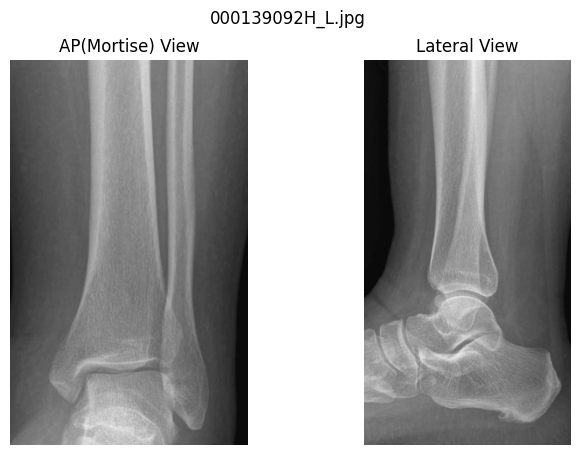

In [157]:
for w3 in wrong3:
    tmp = test_df_front.reset_index(drop=True).iloc[w3]['Filepath']
    plot_img(tmp)


E:\data_bone\9-a+b_swift_cut_正確_V2\front\三踝\001496597A_L.jpg


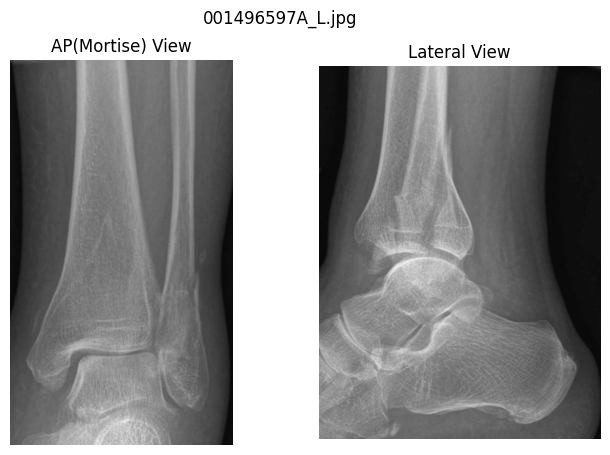

In [156]:
for w4 in wrong4:
    tmp = test_df_front.reset_index(drop=True).iloc[w4]['Filepath']
    plot_img(tmp)

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\001970344H_R.jpg


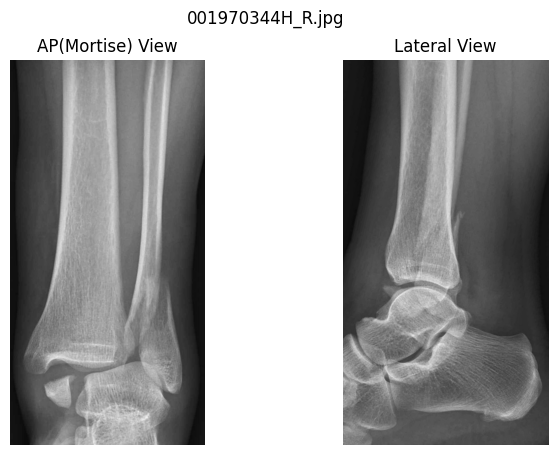

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\002097863G_L.jpg


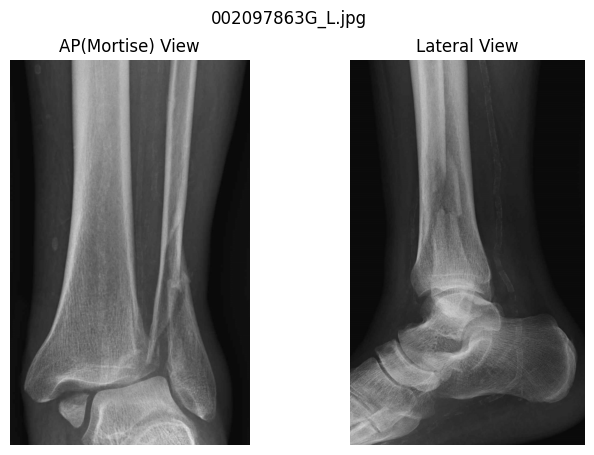

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\002737939B_R.jpg


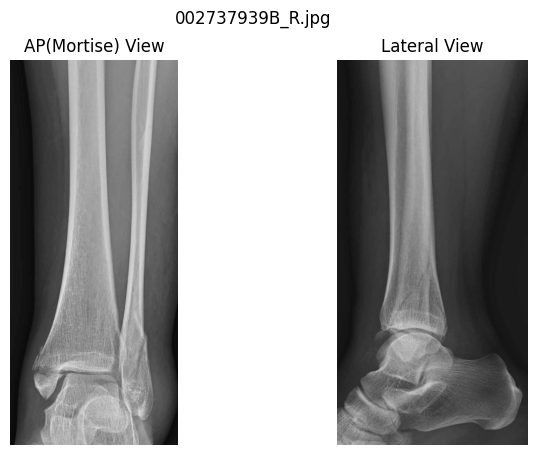

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\002549797G_L.jpg


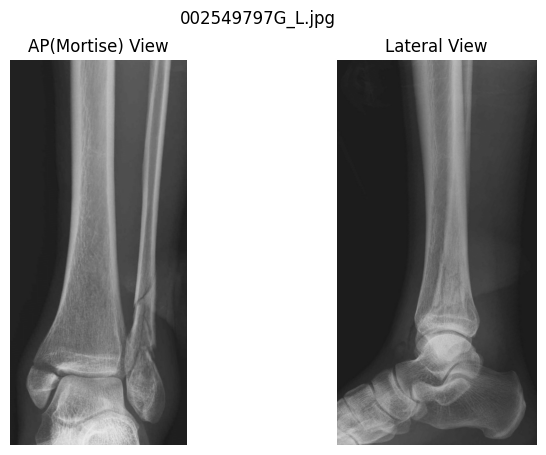

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\002358396C_R.jpg


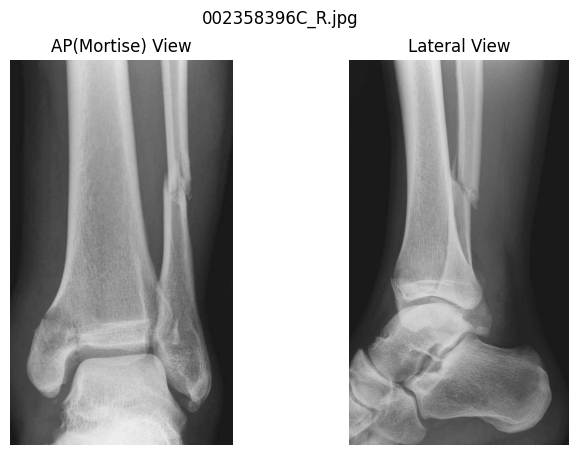

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\000672589J_R.jpg


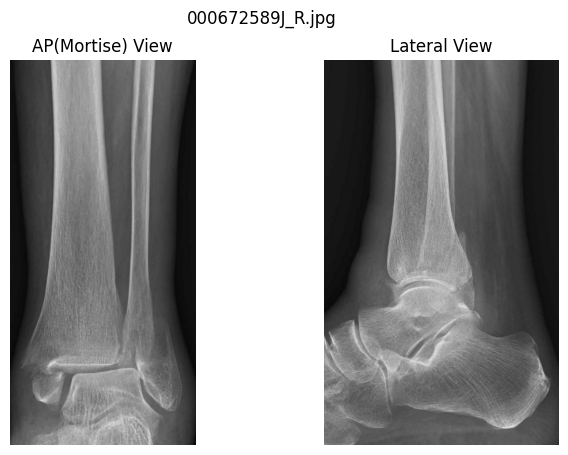

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\002618137D_R.jpg


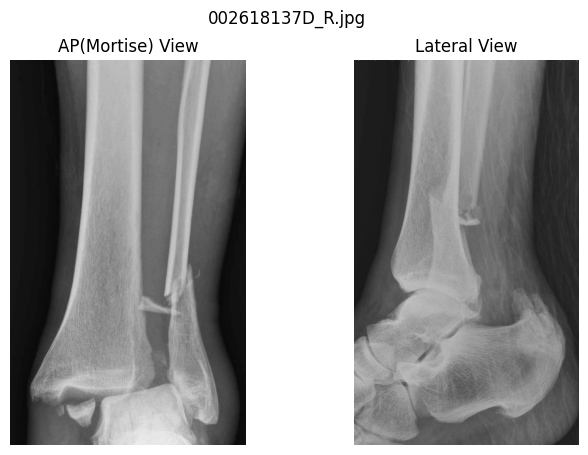

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\002987785I_R.jpg


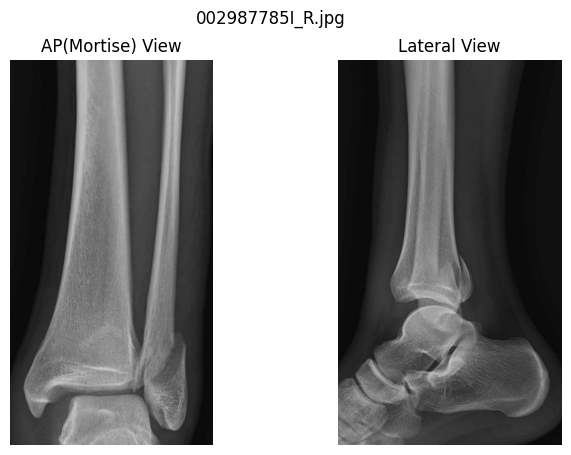

E:\data_bone\9-a+b_swift_cut_正確_V2\front\雙踝\001193773I_L.jpg


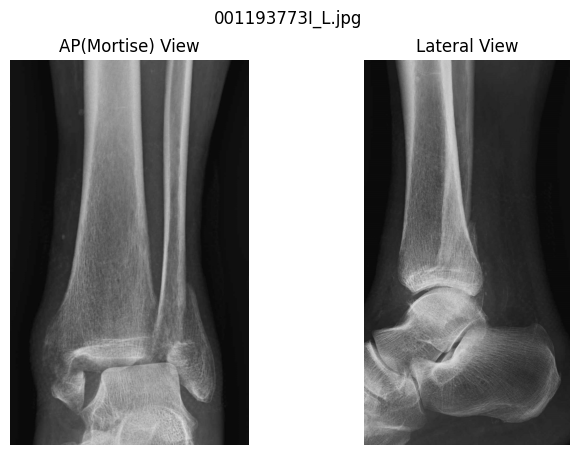

In [153]:
for w1 in wrong1:
    tmp = test_df_front.reset_index(drop=True).iloc[w1]['Filepath']
    plot_img(tmp)
# test_images_side.filenames[12]

E:\data_bone\9-a+b_swift_cut_正確_V2\front\三踝\001842212D_L.jpg


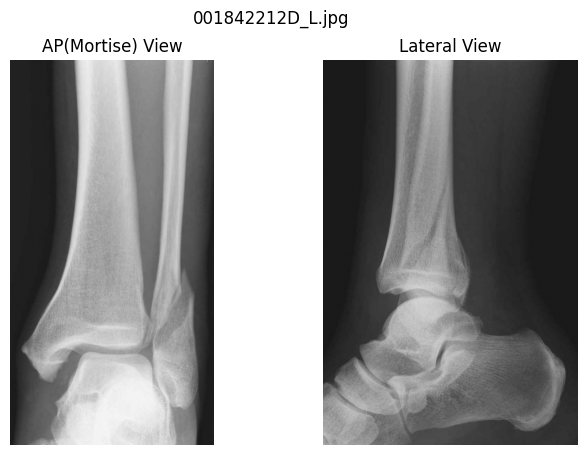

E:\data_bone\9-a+b_swift_cut_正確_V2\front\三踝\000536051A_R.jpg


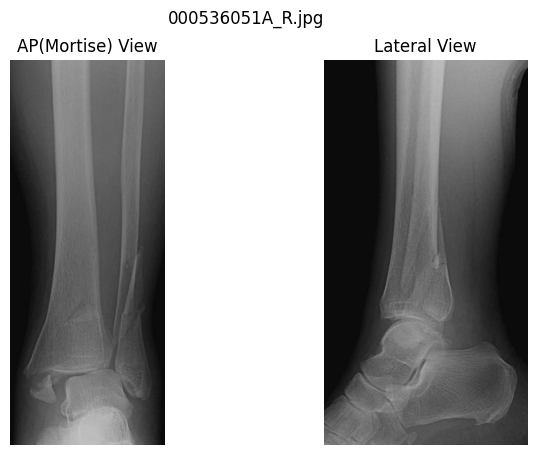

E:\data_bone\9-a+b_swift_cut_正確_V2\front\三踝\000778448H_L.jpg


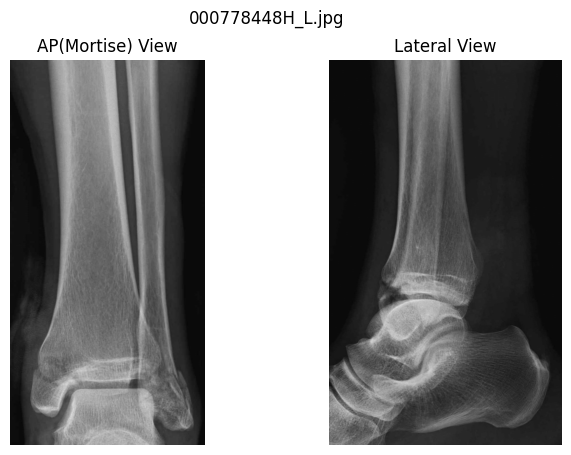

E:\data_bone\9-a+b_swift_cut_正確_V2\front\三踝\000034129H_L.jpg


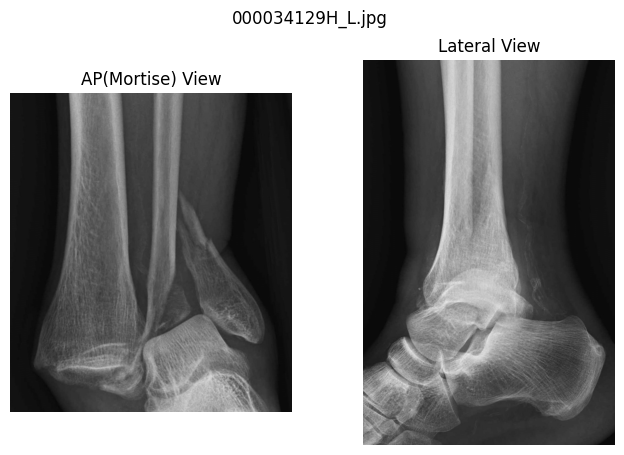

E:\data_bone\9-a+b_swift_cut_正確_V2\front\三踝\001780977H_R.jpg


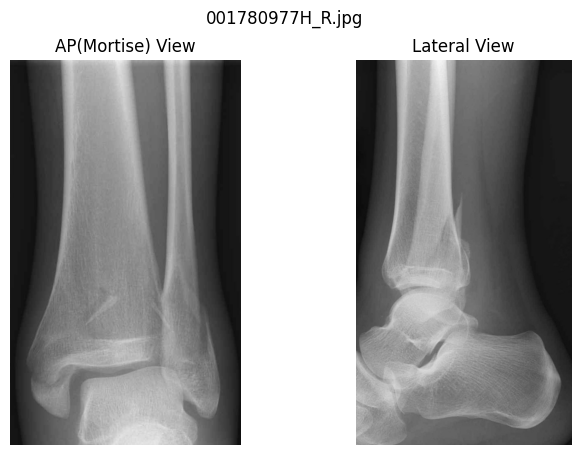

E:\data_bone\9-a+b_swift_cut_正確_V2\front\三踝\002114127F_L.jpg


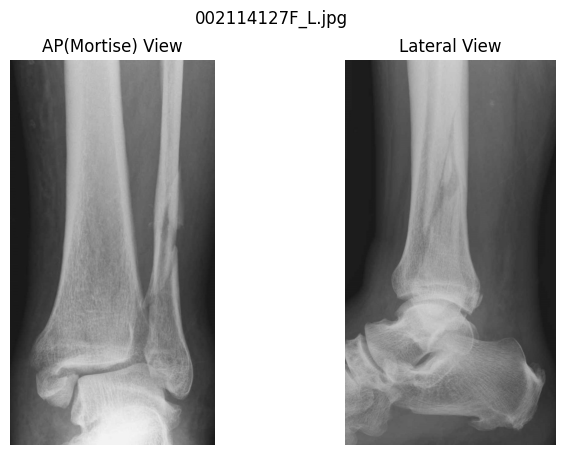

In [152]:
for w2 in wrong2:
    tmp = test_df_front.reset_index(drop=True).iloc[w2]['Filepath']
    plot_img(tmp)
# test_images_side.filenames[12]

In [121]:
# chosen_model = "./weights/concat1__frac.h5"


# for i in range(len(wrong1)):
#     # front
#     im_front = test_df_front.reset_index(drop=True).iloc[i]['Filepath']
#     temp_img = image.load_img(im_front, target_size=(224, 224))
#     x = image.img_to_array(temp_img)
#     x = np.expand_dims(x, axis=0)
#     images_front = np.vstack([x])
#     # side
#     im_side = test_df_front.reset_index(drop=True).iloc[i]['Filepath']
#     temp_img = image.load_img(im_side, target_size=(224, 224))
#     x = image.img_to_array(temp_img)
#     x = np.expand_dims(x, axis=0)
#     images_side = np.vstack([x])

#     heatmap = make_gradcam_heatmap(images_front, images_side, tf.keras.models.load_model(chosen_model))
#     print(f"image path={im}")
#     save_and_display_gradcam(im, heatmap)
#     print("##################################################################################")
# ############################